In [ ]:
import zipfile

with zipfile.ZipFile("/content/sem_bal_mimic_X_y_1h_menos_features.npz", "r") as z:
    z.extract("X.npy", path="/content")
    z.extract("y.npy", path="/content")
    z.extract("mask.npy", path="/content")

print("Arquivos extraídos!")

Arquivos extraídos!


In [ ]:
import numpy as np

X = np.load("/content/X.npy")
y = np.load("/content/y.npy")
mask = np.load("/content/mask.npy")

In [ ]:
!ls -lh /content | grep .npy

-rw-r--r-- 1 root root 3.7M Nov 18 20:45 mask.npy
-rw-r--r-- 1 root root  30M Nov 18 20:45 X.npy
-rw-r--r-- 1 root root 377K Nov 18 20:45 y.npy


In [ ]:
np.savez_compressed("/content/sem_bal_mimic_X_y_1h_menos_features_reparado.npz",
                    X=X,
                    y=y,
                    mask=mask)

In [ ]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix,
    ConfusionMatrixDisplay, accuracy_score, average_precision_score
)
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import BorderlineSMOTE

# --- Carregar dados ---
dados = np.load("/content/sem_bal_mimic_X_y_1h_menos_features_reparado.npz")

X = dados['X']
y = dados['y']
mask = dados['mask']


In [ ]:
# Primeiro: treino (70%) e restante (30%)
X_train, X_temp, y_train, y_temp, mask_train, mask_temp = train_test_split(
    X, y, mask, test_size=0.30, random_state=42, stratify=y
)

# Depois: dividir os 30% restantes em 50/50 -> 15% validação + 15% teste
X_val, X_test, y_val, y_test, mask_val, mask_test = train_test_split(
    X_temp, y_temp, mask_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print(f"Treino: {len(X_train)} amostras ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validação: {len(X_val)} amostras ({len(X_val)/len(X)*100:.1f}%)")
print(f"Teste: {len(X_test)} amostras ({len(X_test)/len(X)*100:.1f}%)")

Treino: 33700 amostras (70.0%)
Validação: 7222 amostras (15.0%)
Teste: 7222 amostras (15.0%)


In [ ]:
def normalize_split_data(X_train, X_val, X_test):
    n_samples, n_janelas, n_features = X_train.shape
    X_train_norm = np.zeros_like(X_train, dtype=np.float32)
    X_val_norm = np.zeros_like(X_val, dtype=np.float32)
    X_test_norm = np.zeros_like(X_test, dtype=np.float32)
    scalers = []

    for i in range(n_features):
        scaler = StandardScaler()
        feat_train = X_train[:, :, i].reshape(-1, 1)
        scaler.fit(feat_train)

        X_train_norm[:, :, i] = scaler.transform(feat_train).reshape(n_samples, n_janelas)
        X_val_norm[:, :, i] = scaler.transform(X_val[:, :, i].reshape(-1, 1)).reshape(X_val.shape[0], n_janelas)
        X_test_norm[:, :, i] = scaler.transform(X_test[:, :, i].reshape(-1, 1)).reshape(X_test.shape[0], n_janelas)

        scalers.append(scaler)

    return X_train_norm, X_val_norm, X_test_norm, scalers

X_train_norm, X_val_norm, X_test_norm, scalers = normalize_split_data(X_train, X_val, X_test)
joblib.dump(scalers, "scalers_standard_lstm.pkl")

['scalers_standard_lstm.pkl']

In [ ]:
n_samples, n_janelas, n_features = X_train_norm.shape
X_train_2d = X_train_norm.reshape(n_samples, -1)

smote = BorderlineSMOTE(sampling_strategy=0.50, random_state=42)
X_res, y_res = smote.fit_resample(X_train_2d, y_train)

# Voltar para 3D
X_train = X_res.reshape(X_res.shape[0], n_janelas, n_features)
y_train = y_res

# Atualizar splits
X_val, X_test = X_val_norm, X_test_norm
input_shape = X_train.shape[1:]

In [ ]:
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, units=32, **kwargs):
        super().__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        self.W = tf.keras.layers.Dense(self.units, use_bias=True)
        self.V = tf.keras.layers.Dense(1, use_bias=False)
        super().build(input_shape)

    def call(self, inputs, mask=None):
        score = self.V(tf.nn.tanh(self.W(inputs)))  # (batch, time, 1)
        score = tf.squeeze(score, axis=-1)          # (batch, time)

        if mask is not None:
            mask = tf.cast(mask, dtype=score.dtype)
            score = score * mask + (1.0 - mask) * -1e9  # ignora padding

        alphas = tf.nn.softmax(score, axis=1)
        alphas_exp = tf.expand_dims(alphas, axis=-1)
        context = tf.reduce_sum(inputs * alphas_exp, axis=1)
        return context

    def get_config(self):
        config = super().get_config()
        config.update({"units": self.units})
        return config

In [ ]:
inputs = tf.keras.Input(shape=input_shape)
x = layers.Masking(mask_value=0.0)(inputs)
x = layers.LSTM(64, return_sequences=True)(x)
context = AttentionLayer(units=32)(x)
x = layers.Dropout(0.3)(context)
x = layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

model.summary()

# ===============================================================
# Treinamento (usando validação separada)
# ===============================================================
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=70,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'attention_layer' (of type AttentionLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 10, 8)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 10, 8)     │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, 10, 8)     │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any (Any)           │ (None, 10)        │          0 │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 10, 64)    │     18,688 │ masking[0][0],    │
│                     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, 64)        │      2,112 │ lstm[0][0],       │
│ (AttentionLayer)    │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         33 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 22,913 (89.50 KB)

 Trainable params: 22,913 (89.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/70
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 28s 14ms/step - accuracy: 0.7114 - auc: 0.7194 - loss: 0.5623 - precision: 0.6061 - recall: 0.3793 - val_accuracy: 0.8223 - val_auc: 0.7770 - val_loss: 0.4218 - val_precision: 0.3972 - val_recall: 0.5054
Epoch 2/70
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.7389 - auc: 0.7789 - loss: 0.5220 - precision: 0.6468 - recall: 0.4820 - val_accuracy: 0.8194 - val_auc: 0.7835 - val_loss: 0.4123 - val_precision: 0.3923 - val_recall: 0.5143
Epoch 3/70
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.7477 - auc: 0.7879 - loss: 0.5125 - precision: 0.6605 - recall: 0.5032 - val_accuracy: 0.8345 - val_auc: 0.7824 - val_loss: 0.3990 - val_precision: 0.4210 - val_recall: 0.4661
Epoch 4/70
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.7479 - auc: 0.7926 - loss: 0.5055 - precision: 0.6616 - recall: 0.4804 - val_accuracy: 0.8028 - val_auc: 0.7849 - val_loss: 0.4456 - val_precision: 0.3676 - val_recall: 0.5556
Epoch 5/70
1358/

226/226 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

--- Resultados no conjunto de TESTE ---
Acurácia: 0.8323
AUC: 0.7780
Precisão: 0.4121
Revocação: 0.4474
F1-score: 0.4290
AUPRC: 0.4021


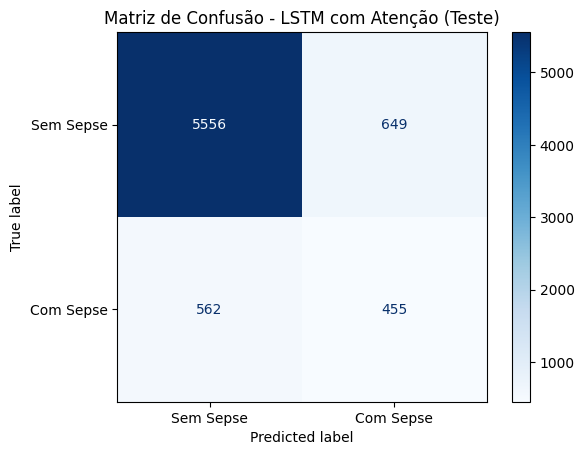

In [ ]:
# ===============================================================
# Avaliação final no conjunto de teste (15%)
# ===============================================================
y_pred_prob = model.predict(X_test).flatten()
y_pred = (y_pred_prob >= 0.5).astype(int)

print("\n--- Resultados no conjunto de TESTE ---")
print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}")
print(f"AUC: {roc_auc_score(y_test, y_pred_prob):.4f}")
print(f"Precisão: {precision_score(y_test, y_pred):.4f}")
print(f"Revocação: {recall_score(y_test, y_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred):.4f}")
print(f"AUPRC: {average_precision_score(y_test, y_pred_prob):.4f}")

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Sem Sepse", "Com Sepse"])
disp.plot(cmap='Blues')
plt.title("Matriz de Confusão - LSTM com Atenção (Teste)")
plt.show()